## Testing of trained models

### Imports

In [1]:
import torch
from IPython.display import display, HTML, Image
from torch_geometric.loader import DataLoader
import pandas as pd
import seaborn as sns

from settings import *
from generator import generate_organism
from GNCAConv import Conv
from visualizer import Visualizer
from evo_trainer import Evo_Trainer
from enums import EnvironmentType, ModelType, SettingType
from food_env import *
from online_tracker import OnlineTracker

### Helper methods

In [2]:
def load_food_envs(wall_amount, food_amount, scale):
    #TODO need some way of making food_amount have effect on cluster_env, grid_env and lab_env
    wall_amount = wall_amount*scale
    food_amount = food_amount*scale
    centered_env = Centered_Env(food_amount=food_amount, wall_amount=wall_amount//4)
    cluster_env = Cluster_Env(clusters=80*scale, cluster_size=15, wall_amount=wall_amount//3)
    circle_env = Circle_Env(circles=3*scale, food_amount=food_amount*4, wall_amount=wall_amount//4)
    spiral_env = Spiral_Env(spirals=3, food_amount=food_amount, wall_amount=wall_amount)
    bottleneck_env = Bottleneck_Env(food_amount=food_amount//2, wall_amount=(wall_amount*16)//25)
    grid_env = Grid_Env(cluster_size=25, grid_size=6*scale)
    food_grid_env = Food_Grid_Env(cluster_size=25, grid_size=3*scale)
    lab_env = Labyrinth_Env(cluster_size=40, grid_size=(5*scale)//2)
    #return [centered_env, cluster_env, circle_env, spiral_env, bottleneck_env, grid_env, lab_env]
    return [cluster_env, circle_env, spiral_env, grid_env, lab_env, food_grid_env]

def get_default_settings(model_name): #the settings all models are trained on
    scale = 4
    train_config = Train_Config(stdev=0.1, popsize=10, 
        name=model_name, problem_searcher=ProblemSearcher.CMAES,
        with_samplepool=False, timesteps=1000)

    settings = Settings(
        device = torch.device('cpu'),
        batch_size = 1,
        cells = 100,
        #food_envs=[centered_env, cluster_env, circle_env, spiral_env, bottleneck_env, grid_env, lab_env],
        food_envs=load_food_envs(100, 500, scale),
        scale = scale,
        wrap_around = False,
        
        model_type = ModelType.Local,
        #model_type = ModelType.WithGlobalNode,
        #model_type = ModelType.SmallWorld,

        radius = 0.04,
        radius_food_scale = 5,
        consume_radius_scale = 0.8, 
        noise = 0.001,
        energy_required_to_replicate = 80,
        train_config=train_config,
        max_degree = 9,

        radius_wall_scale = 5,
        radius_wall_damage_scale = 3,
        wall_damage = 20,
        radius_long_scale=4,
    )
    return settings

In [3]:
def load_model(settings):
    model = Conv(settings=settings)
    model.load_state_dict(torch.load('../models/' + settings.train_config.name + '.pth'))
    return model

In [4]:
def test_model(model, settings, times):
    '''Method for running a given model and setting config on each env type x times'''
    df_temp = pd.DataFrame(columns=['ModelName', 'EnvType', 'FoodScore', 'TimeScore'])

    for food_env in settings.food_envs:
        for _ in range(times): #batch size 1
            graphs = [generate_organism(settings).toGraph(food_env) for _ in range(settings.batch_size)]
            loader = DataLoader(graphs, batch_size=settings.batch_size)
            graph = next(iter(loader))
            with torch.no_grad():
                graph = model(graph, settings.train_config.timesteps)
            df_temp = df_temp.append({'ModelName': settings.train_config.name, 'EnvType': food_env.env_type, 'FoodScore': graph.food_reward.detach().numpy(), 'TimeScore': graph.cells_alive.detach().numpy() / settings.n}, ignore_index=True)
    return df_temp

In [5]:
def test_models_default(models, times):
    '''Method for loading and running all models on base settings'''
    df_values = pd.DataFrame(columns=['ModelName', 'EnvType', 'FoodScore', 'TimeScore'])

    for model_name in models:
        settings = get_default_settings(model_name)
        model = load_model(settings)

        df_temp = test_model(model, settings, times)
        df_values = df_values.append(df_temp, ignore_index=True)
    return df_values

#### Used for variation

In [6]:
def test_models_variable(model, settings, times, setting_type, setting_value):
    '''Method for testing specific model'''
    df_temp = test_model(model, settings, times)
    #setting_types = [setting_type] * (times*len(settings.food_envs))
    df_temp.insert(2, 'SettingType', setting_type)
    df_temp.insert(3, 'SettingValue', setting_value)
    return df_temp

In [7]:
def change_settings(settings, setting_type, value):
    match setting_type:
        case SettingType.Cells:
            settings.n = value
        case SettingType.Obstacles:
            settings.food_envs = load_food_envs(value, 500, settings.scale)
        case SettingType.FoodAmount:
            settings.food_envs = load_food_envs(100, value, settings.scale)
        case SettingType.CellRadius: 
            settings.radius = value
        case SettingType.FoodRadiusScale:
            settings.radius_food_scale = value
        case SettingType.ObstacleRadiusScale:
            settings.radius_wall_scale = value
        case SettingType.Noise:
            settings.noise = value
    #TODO if we add smallWorld model type, then also test varying that one... - or maybe not - we vary cell radius itself...

In [8]:
#setup all configs for specific setting variable
def test_models_all_variables(models, times, setting_types):
    df_values = pd.DataFrame(columns=['ModelName', 'EnvType', 'SettingType', 'SettingValue', 'FoodScore', 'TimeScore'])


    #for setting_type in range(len(setting_variables)):
    for setting_type in setting_types:
        for setting_value in setting_types[setting_type]:
            for model_name in models:
                settings = get_default_settings(model_name)
                change_settings(settings, setting_type, setting_value)
                model = load_model(settings)
                df_temp = test_models_variable(model, settings, times, setting_type, setting_value)
                df_values = df_values.append(df_temp, ignore_index=True)
    return df_values


#### Plots 

In [9]:
#Helper method for doing analysis on the results 
def barplot(df, y):
    #df["EnvTypeValue"] = df["EnvType"].apply(lambda x: getattr(EnvironmentType, x).value)
    df["EnvTypeValue"] = df["EnvType"].apply(lambda x: x.name)
    df_mean = df.groupby(['ModelName', 'EnvTypeValue'], as_index=False).mean()
    ax = sns.barplot(data=df_mean, x='EnvTypeValue', hue='ModelName', y=y)
    ax.set(xlabel='Environment Type', ylabel=y)
    return ax

In [10]:
def barplot_settingType(df, y, setting_type):
    #TODO add name to plot so we know it's filtered on setting type
    df = df.loc[df['SettingType'] == setting_type]
    ax = barplot(df, y)
    ax.set_title('SettingType: ' + setting_type.name)

In [11]:
#Helper method for plotting these results 
#maybe histplot/barplot with each model/env combo in each bar with average and best... at y
#show all models at each bar for each env so its easy to compare which models performs best on which envs

In [12]:
def lineplot(df, setting_type, y, env_type=None):
    '''Plot how well models do on varying specific setting variable'''
    #TODO if env_type is not None specify which env in name or else say all
    #TODO specify x axis value of setting_type

    df = df.loc[df['SettingType'] == setting_type]
    if env_type is not None:
        df["EnvTypeValue"] = df["EnvType"].apply(lambda x : x.name)
        df = df.loc[df['EnvTypeValue'] == env_type.name]

    #df["SettingValue"] = df["SettingValue"].apply(lambda x : x.value)
    df = df.groupby(['ModelName', 'SettingValue'], as_index=False)
    df_mean = df.mean()

    ax = sns.lineplot(
        data=df_mean,
        x="SettingValue", y=y, hue="ModelName", style="ModelName", ci='sd',
        markers=True, dashes=False
    )
    ax.set(xlabel=setting_type.name, ylabel=y)
    if env_type is None:
        ax.set_title('Environment: All')
    else:
        ax.set_title('Environment: ' + env_type.name)
    #TODO give name

### Test models on trained env

In [13]:
#settings = get_default_settings('GAT1_localOnly')
#model = load_model(settings)
#df = test_model(model, settings, 10)

In [14]:
#Names of models to test
#models = ['GAT1_localOnly', 'GAT1_localOnly_hpc']
#models = ['GAT1_localOnly_hpc', 'GAT2_localOnly']
models = ['GAT3_local']
times = 10

In [15]:
df_values = test_models_default(models, times)

In [16]:
df_values

ModelName                    EnvType FoodScore TimeScore
0   GAT3_local   EnvironmentType.Clusters    [77.0]    [48.0]
1   GAT3_local   EnvironmentType.Clusters    [94.0]    [58.1]
2   GAT3_local   EnvironmentType.Clusters   [106.0]   [96.46]
3   GAT3_local   EnvironmentType.Clusters   [128.0]   [40.48]
4   GAT3_local   EnvironmentType.Clusters   [204.0]   [58.67]
5   GAT3_local   EnvironmentType.Clusters   [121.0]   [80.26]
6   GAT3_local   EnvironmentType.Clusters   [304.0]  [142.89]
7   GAT3_local   EnvironmentType.Clusters   [168.0]   [85.33]
8   GAT3_local   EnvironmentType.Clusters    [15.0]   [17.03]
9   GAT3_local   EnvironmentType.Clusters    [28.0]   [61.29]
10  GAT3_local   EnvironmentType.Circular   [206.0]  [132.81]
11  GAT3_local   EnvironmentType.Circular     [0.0]    [47.0]
12  GAT3_local   EnvironmentType.Circular     [0.0]    [47.0]
13  GAT3_local   EnvironmentType.Circular   [201.0]  [111.55]
14  GAT3_local   EnvironmentType.Circular     [0.0]    [47.0]
15  GAT3_local   EnvironmentType.Circular   [157.0]   [77.69]
16  GAT3_local   EnvironmentType.Circular   [112.0]   [92.56]
17  GAT3_local   EnvironmentType.Circular     [0.0]    [47.0]
18  GAT3_local   EnvironmentType.Circular     [0.0]    [47.0]
19  GAT3_local   EnvironmentType.Circular   [282.0]  [138.32]
20  GAT3_local     EnvironmentType.Spiral   [324.0]  [190.74]
21  GAT3_local     EnvironmentType.Spiral   [196.0]  [109.07]
22  GAT3_local     EnvironmentType.Spiral   [183.0]  [116.14]
23  GAT3_local     EnvironmentType.Spiral   [288.0]   [173.5]
24  GAT3_local     EnvironmentType.Spiral    [97.0]    [62.8]
25  GAT3_local     EnvironmentType.Spiral   [203.0]  [139.64]
26  GAT3_local     EnvironmentType.Spiral    [30.0]   [42.92]
27  GAT3_local     EnvironmentType.Spiral   [176.0]  [103.68]
28  GAT3_local     EnvironmentType.Spiral   [311.0]  [220.03]
29  GAT3_local     EnvironmentType.Spiral    [11.0]   [23.07]
30  GAT3_local       EnvironmentType.Grid    [60.0]   [84.36]
31  GAT3_local       EnvironmentType.Grid    [58.0]   [82.87]
32  GAT3_local       EnvironmentType.Grid    [60.0]   [84.62]
33  GAT3_local       EnvironmentType.Grid    [62.0]   [84.61]
34  GAT3_local       EnvironmentType.Grid    [64.0]   [86.72]
35  GAT3_local       EnvironmentType.Grid    [68.0]   [88.73]
36  GAT3_local       EnvironmentType.Grid    [67.0]   [88.53]
37  GAT3_local       EnvironmentType.Grid    [59.0]   [83.73]
38  GAT3_local       EnvironmentType.Grid    [71.0]   [91.55]
39  GAT3_local       EnvironmentType.Grid    [60.0]   [84.71]
40  GAT3_local  EnvironmentType.Labyrinth    [86.0]   [63.63]
41  GAT3_local  EnvironmentType.Labyrinth     [0.0]   [46.74]
42  GAT3_local  EnvironmentType.Labyrinth    [67.0]   [42.72]
43  GAT3_local  EnvironmentType.Labyrinth    [83.0]   [52.68]
44  GAT3_local  EnvironmentType.Labyrinth    [86.0]    [49.5]
45  GAT3_local  EnvironmentType.Labyrinth     [9.0]   [34.97]
46  GAT3_local  EnvironmentType.Labyrinth     [4.0]   [27.32]
47  GAT3_local  EnvironmentType.Labyrinth    [71.0]   [49.39]
48  GAT3_local  EnvironmentType.Labyrinth   [103.0]   [67.42]
49  GAT3_local  EnvironmentType.Labyrinth     [0.0]    [47.0]
50  GAT3_local  EnvironmentType.Food_Grid     [0.0]    [47.0]
51  GAT3_local  EnvironmentType.Food_Grid     [0.0]    [47.0]
52  GAT3_local  EnvironmentType.Food_Grid     [0.0]    [47.0]
53  GAT3_local  EnvironmentType.Food_Grid     [0.0]    [47.0]
54  GAT3_local  EnvironmentType.Food_Grid     [0.0]    [47.0]
55  GAT3_local  EnvironmentType.Food_Grid     [0.0]    [47.0]
56  GAT3_local  EnvironmentType.Food_Grid     [0.0]   [46.99]
57  GAT3_local  EnvironmentType.Food_Grid     [0.0]    [47.0]
58  GAT3_local  EnvironmentType.Food_Grid     [0.0]    [47.0]
59  GAT3_local  EnvironmentType.Food_Grid     [0.0]    [47.0]

/var/folders/gr/v_6cxqhs7m5d538mpxzczl140000gn/T/ipykernel_50159/1660972418.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  barplot(df_values, 'FoodScore')


<AxesSubplot:xlabel='Environment Type', ylabel='FoodScore'>

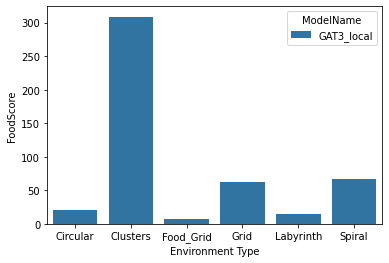

In [17]:
barplot(df_values, 'FoodScore')

/var/folders/gr/v_6cxqhs7m5d538mpxzczl140000gn/T/ipykernel_41215/2545040806.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  barplot(df_values, 'TimeScore')


<AxesSubplot:xlabel='Environment Type', ylabel='TimeScore'>

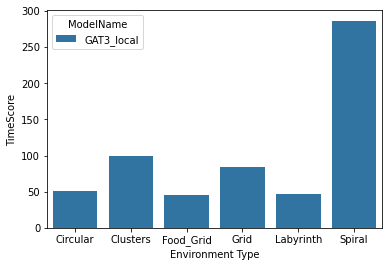

In [18]:
barplot(df_values, 'TimeScore')

### Setup all testing options

Make a plot simply on each model and environment type of how well they perform on different sizes of cells

### Test on specified options

Make plots on how well each model (in different colors) perform on specific option being varied (x) - food and time on y

Maybe across all envs or one plot pr env

Make some summarizing plot (x being env type or setting combo) where y is mean over all in group and hue is model again

In [ ]:
cells = [10, 50, 100, 200, 500, 1000]
walls = [0, 50, 100, 200]
food_amount = [300, 500, 700, 1000]
radius = [0.02, 0.04, 0.06, 0.08]
radius_food_scale = [3, 5, 7, 9]
radius_wall_scale = [3, 5, 7, 9]
noise = [0.0, 0.001, 0.002, 0.005]
#TODO edge randomly removed
#TODO nodes randomly removed
#TODO random noise in nodes hidden layers

setting_types = { SettingType.Cells: cells, SettingType.Obstacles: walls, SettingType.FoodAmount: food_amount,
                     SettingType.CellRadius: radius, SettingType.FoodRadiusScale: radius_food_scale, 
                     SettingType.ObstacleRadiusScale: radius_wall_scale, SettingType.Noise: noise
                     }
setting_types = { SettingType.FoodRadiusScale: radius_food_scale}
#setting_variables = [cells, walls, food_amount, radius, radius_food_scale, radius_wall_scale, noise]

In [ ]:
df_variable_values = test_models_all_variables(models, times, setting_types)

KeyboardInterrupt: 

/var/folders/gr/v_6cxqhs7m5d538mpxzczl140000gn/T/ipykernel_93584/365415372.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  lineplot(df_variable_values, SettingType.FoodRadiusScale, 'TimeScore', env_type=EnvironmentType.Spiral)


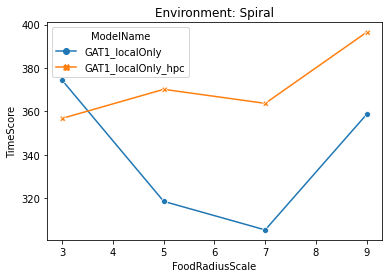

In [ ]:
#Specific settingType over Specific EnvType
lineplot(df_variable_values, SettingType.FoodRadiusScale, 'TimeScore', env_type=EnvironmentType.Spiral)

/var/folders/gr/v_6cxqhs7m5d538mpxzczl140000gn/T/ipykernel_93584/3097649580.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  lineplot(df_variable_values, SettingType.FoodRadiusScale, 'TimeScore', env_type=None)


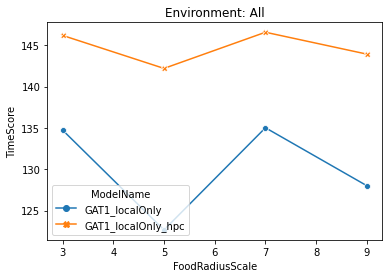

In [ ]:
#Specific settingType over all EnvTypes
lineplot(df_variable_values, SettingType.FoodRadiusScale, 'TimeScore', env_type=None)

/var/folders/gr/v_6cxqhs7m5d538mpxzczl140000gn/T/ipykernel_93584/2366430846.py:4: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  ax = barplot(df, y)


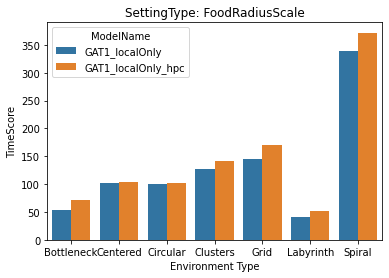

In [ ]:
#Barplot of specific settingType on each env
barplot_settingType(df_variable_values, 'TimeScore', SettingType.FoodRadiusScale)

/var/folders/gr/v_6cxqhs7m5d538mpxzczl140000gn/T/ipykernel_93584/3341221817.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  ax = barplot(df_variable_values, 'TimeScore')


Text(0.5, 1.0, 'SettingType: All')

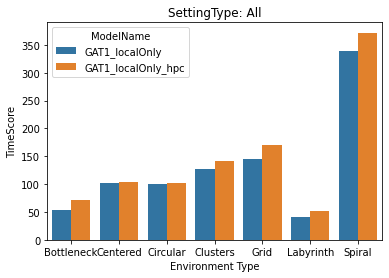

In [ ]:
#Barplot of generalizability of models on each Env for all variables
ax = barplot(df_variable_values, 'TimeScore')
ax.set_title('SettingType: All')

In [ ]:
df_variable_values

ModelName                    EnvType SettingType SettingValue  \
0        GAT1_localOnly   EnvironmentType.Centered           4            3   
1        GAT1_localOnly   EnvironmentType.Centered           4            3   
2        GAT1_localOnly   EnvironmentType.Centered           4            3   
3        GAT1_localOnly   EnvironmentType.Centered           4            3   
4        GAT1_localOnly   EnvironmentType.Centered           4            3   
..                  ...                        ...         ...          ...   
275  GAT1_localOnly_hpc  EnvironmentType.Labyrinth           4            9   
276  GAT1_localOnly_hpc  EnvironmentType.Labyrinth           4            9   
277  GAT1_localOnly_hpc  EnvironmentType.Labyrinth           4            9   
278  GAT1_localOnly_hpc  EnvironmentType.Labyrinth           4            9   
279  GAT1_localOnly_hpc  EnvironmentType.Labyrinth           4            9   

    FoodScore TimeScore EnvTypeValue  
0     [202.0]  [103.85]     Centered  
1     [400.0]  [117.02]     Centered  
2     [246.0]   [86.36]     Centered  
3     [292.0]   [90.77]     Centered  
4     [225.0]   [90.24]     Centered  
..        ...       ...          ...  
275   [227.0]   [53.13]    Labyrinth  
276   [257.0]   [75.43]    Labyrinth  
277   [149.0]   [44.74]    Labyrinth  
278    [68.0]   [35.92]    Labyrinth  
279   [144.0]   [41.47]    Labyrinth  

[280 rows x 7 columns]

Loop through all combis of settingType and env_type or no env_type

### Visualize 

In [15]:
#TODO somehow ensure we hardcoded test on one of each environment
settings = get_default_settings(models[0])
model = load_model(settings)
graphs = [generate_organism(settings).toGraph(settings.food_envs[4]) for _ in range(settings.batch_size)]
loader = DataLoader(graphs, batch_size=settings.batch_size)
graph = next(iter(loader))
visualizer = Visualizer(settings)
model(graph, 0)

DataBatch(x=[6850, 11], edge_index=[1, 0], device=[1], subsize=[1], velocity=[1], pos_reward=[1], border_cost=[1], food_reward=[1], dead_cost=[1], visible_food=[1], food_avg_dist=[1], food_avg_degree=[1], food_search_movement=[1], cells_alive=[1], timesteps=[1], batch=[6850], ptr=[2])

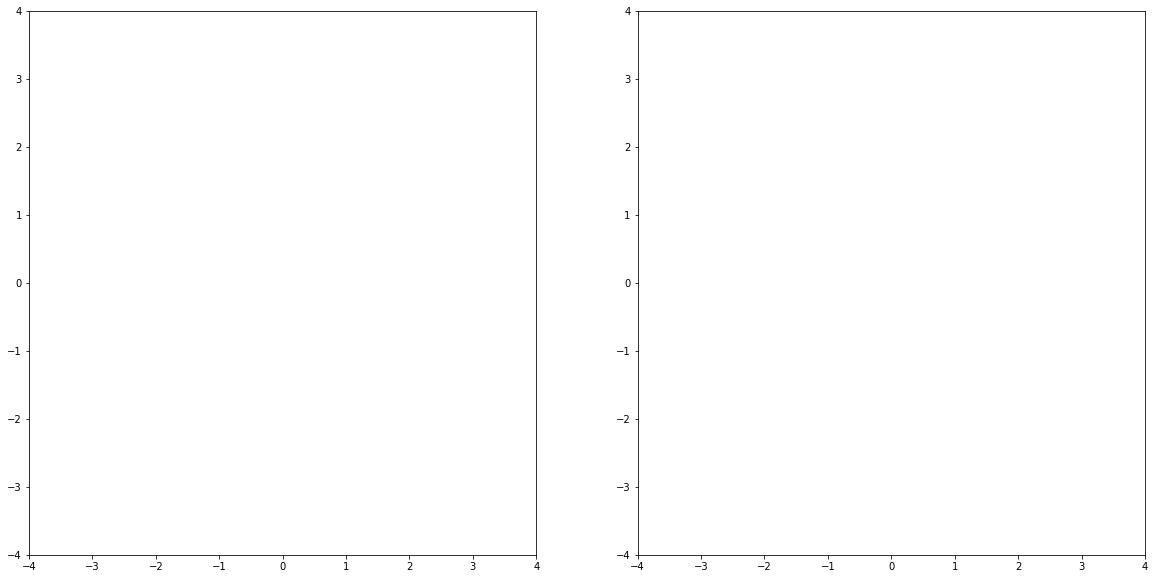

In [16]:
dpi = 100 #beautiful
#dpi = 50 #fast

anim = visualizer.animate_organism(graph, model) 
visualizer.save_animation_to_gif(anim, settings.train_config.name + '_test1', fps=10, dpi=dpi)

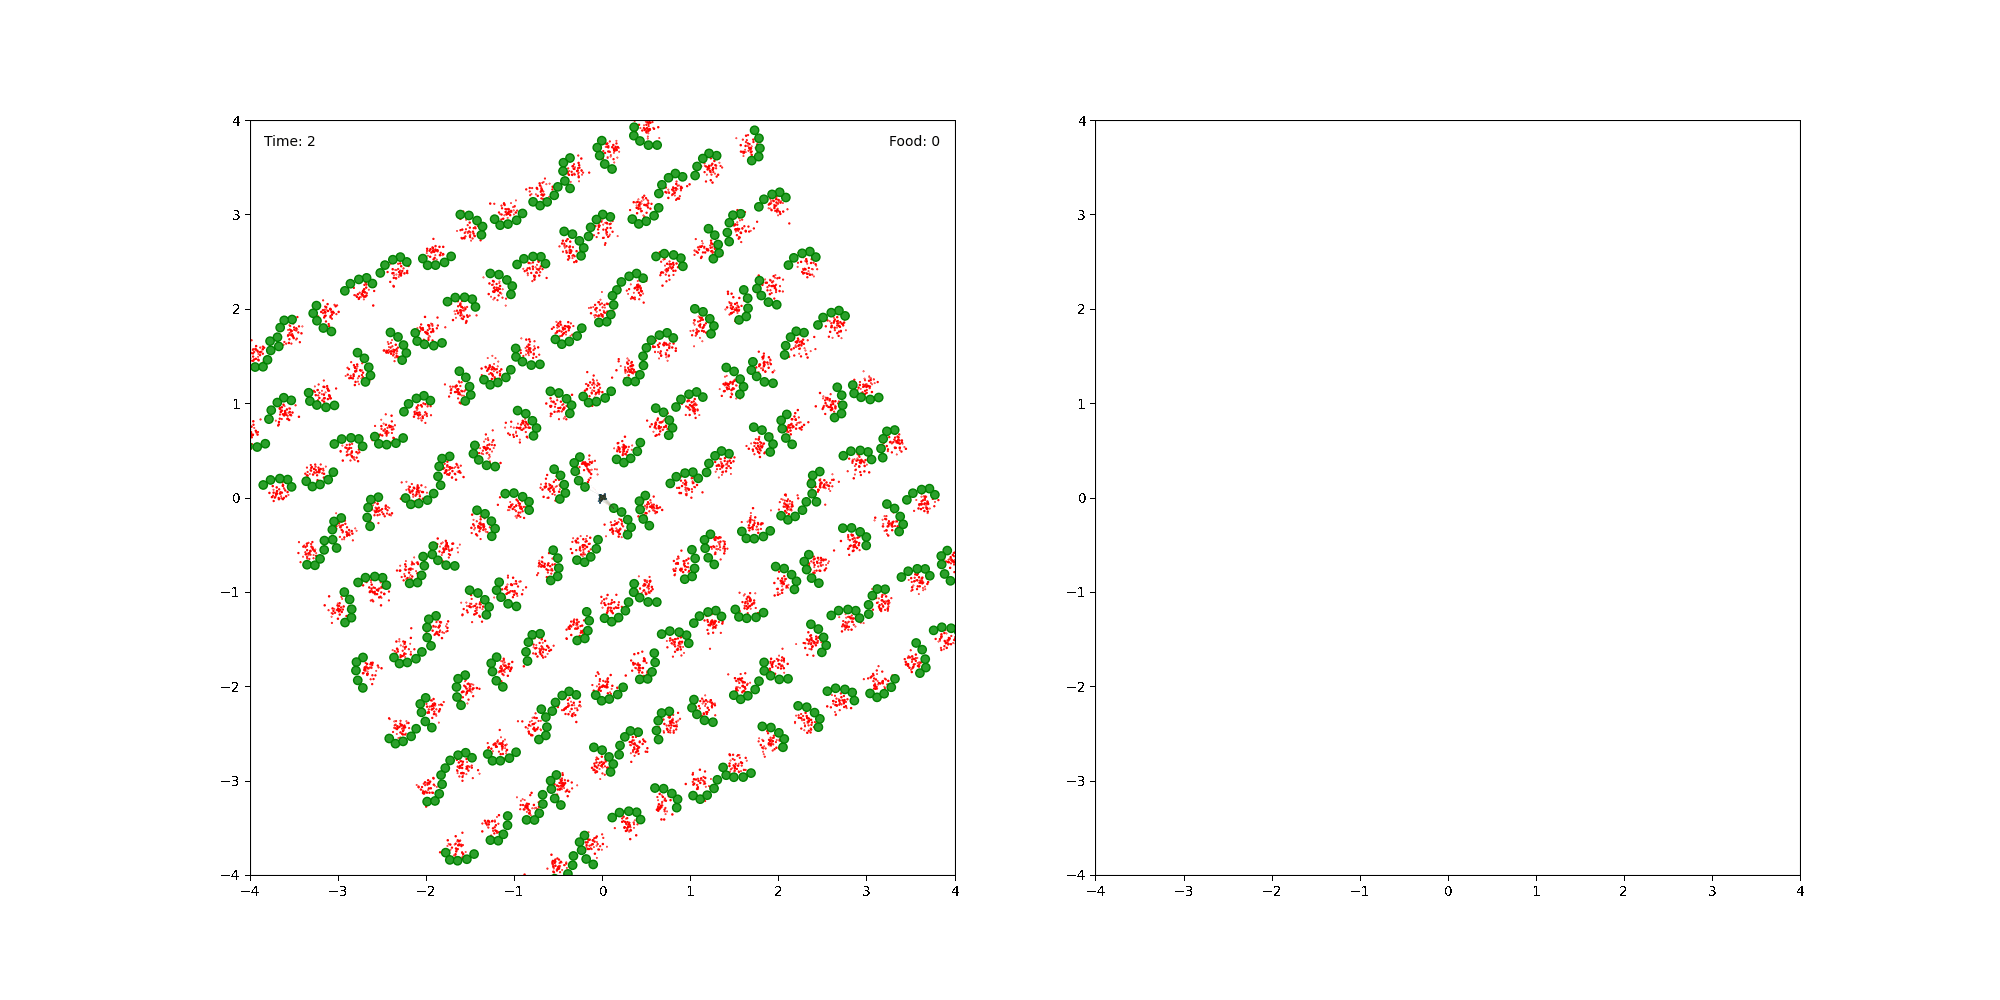

In [17]:
Image('../animation/' + settings.train_config.name + '_test1.gif')

### Plot average of performance on different settings for each mode type

perform x tests on each configuration for each mode and see which performs best in each and across each config

In [ ]:
#

### Benchmarking

need some benchmarkings in how fast each models work on different sizes depending on food and cells..
Plot size on x and time on y

To know how well the framework scales

In [ ]:
x = torch.tensor([1,2,3,4,5])
s = 3
x[-5:]

tensor([1, 2, 3, 4, 5])

In [80]:
x = torch.tensor([[1,2], [3,4], [5,6]], dtype=torch.float)
torch.norm(x, dim=1)

tensor([2.2361, 5.0000, 7.8102])

In [82]:
import torch.nn.functional as F
x_norm = x / torch.norm(x, dim=1, keepdim=True)
x_norm2 = F.normalize(x, dim=1)
print(x_norm, x_norm2)
print(x_norm2)

tensor([[0.4472, 0.8944],
        [0.6000, 0.8000],
        [0.6402, 0.7682]]) tensor([[0.4472, 0.8944],
        [0.6000, 0.8000],
        [0.6402, 0.7682]])
tensor([[0.4472, 0.8944],
        [0.6000, 0.8000],
        [0.6402, 0.7682]])


In [34]:
#torch.einsum('bni,bmi->bnm', x_norm, x_norm)
torch.acos(torch.sum(x_norm * x_norm, dim=1))
torch.acos(torch.dot(x_norm[1], x_norm[1]))

tensor(0.)

In [47]:
torch.acos(torch.tensor([-1.]))

tensor([3.1416])

In [87]:
x1 = torch.tensor([[1.0, 1.0]])
x2 = torch.tensor([[0.0, 1.0]])
x3 = torch.cat((x1, x2), dim=0)
torch.angle(x3)

tensor([[0., 0.],
        [0., 0.]])

In [76]:
zero = torch.tensor([[0.0, 0.0]])
norm = F.normalize(zero)
sum = torch.sum(norm * norm)
torch.acos(sum)
torch.acos(torch.tensor(0.0))

tensor(1.5708)

In [89]:
import torch
import torch.nn.functional as F

# Assume these are your 2D tensors
A = torch.randn(100, 2)
B = torch.randn(100, 2)

# Compute norms of A and B
norm_A = A.norm(dim=1).unsqueeze(1)
norm_B = B.norm(dim=1).unsqueeze(1)

# Compute dot product
dot_prod = A @ B.t()

# Compute cosine of angles
cos_theta = dot_prod / (norm_A * norm_B.t())

# Clip values to avoid numerical issues
cos_theta = torch.clamp(cos_theta, -1.0, 1.0)

# Compute angles in radians
theta = torch.acos(cos_theta)

# If you want the angles in degrees
theta_degrees = theta * 180 / torch.pi
theta_degrees

tensor([[ 72.4307, 151.4649,  74.1347,  ...,   4.4758, 133.3432, 179.4511],
        [ 43.7787,  35.2555,  42.0747,  ..., 120.6852,  17.1339,  64.3398],
        [143.1167, 137.8492, 144.8206,  ...,  66.2102, 155.9708, 108.7649],
        ...,
        [ 68.3063, 147.3405,  70.0103,  ...,   8.6002, 129.2189, 176.4248],
        [162.9510,  83.9168, 161.2470,  ..., 120.1425, 102.0384,  54.8325],
        [156.0608,  77.0266, 154.3568,  ..., 127.0327,  95.1482,  47.9424]])

In [156]:
import torch
import torch.nn.functional as F

# Assume these are your 2D tensors
A = torch.randn(100000, 2)
B = torch.randn(100000, 2)

# Compute norms of A and B
norm_A = A.norm(dim=1, keepdim=True)
norm_B = B.norm(dim=1, keepdim=True)

# Compute dot product elementwise
dot_prod = (A * B).sum(dim=1, keepdim=True)

# Compute cosine of angles
cos_theta = dot_prod / (norm_A * norm_B)

# Clip values to avoid numerical issues
cos_theta = torch.clamp(cos_theta, -1.0, 1.0)

# Compute angles in radians
theta = torch.acos(cos_theta)

# If you want the angles in degrees
theta_degrees = theta * 180 / torch.pi
torch.any(torch.isnan(theta_degrees))

tensor(False)

In [157]:
1e-7

1e-07

In [220]:
from torch_geometric.nn.norm import pair_norm
pairNorm = pair_norm.PairNorm()
A = torch.randn(100000, 2)
A = torch.ones(10000, 2)
torch.any(torch.isnan(pairNorm(A)))

tensor(False)

In [261]:
ax = torch.tensor([[2.0, 0.0], [1.0, 1.0]])
x = torch.tensor([[-0.9, 0.9], [0.0, 0.1]])
ax_norm = torch.norm(ax, dim=1, keepdim=True)
x_norm = torch.norm(x, dim=1, keepdim=True)

angle = torch.acos(torch.clamp((ax * x).sum(dim=1, keepdim=True) / (ax_norm * x_norm + 1e-7), -1.0, 1.0))
#180 * angle / torch.pi

relative_angles = torch.atan2(ax[:, 1], ax[:, 0]) - torch.atan2(x[:, 1], x[:, 0])
# Normalize to [-pi, pi]
relative_angles = (relative_angles.unsqueeze(1) + torch.pi) % (2 * torch.pi) - torch.pi

print(torch.rad2deg(angle))
print(torch.rad2deg(relative_angles))


tensor([[135.0000],
        [ 45.0000]])
tensor([[-135.0000],
        [ -45.0000]])


In [262]:
angle_A = torch.atan2(ax[:, 0], ax[:, 1])

# Compute cosines and sines of angles
cos_angle_A = torch.cos(angle_A)
sin_angle_A = torch.sin(angle_A)

# Construct batch of rotation matrices
rotation_matrices = torch.stack((cos_angle_A, -sin_angle_A, sin_angle_A, cos_angle_A), dim=1).view(-1, 2, 2)

# Apply rotations to B
B_rotated = torch.bmm(rotation_matrices, x.unsqueeze(-1)).squeeze(-1)

inverse_rotation = rotation_matrices.transpose(1, 2)
B1 = torch.bmm(inverse_rotation, B_rotated.unsqueeze(-1)).squeeze(-1)
#B1
B_rotated

tensor([[-0.9000, -0.9000],
        [-0.0707,  0.0707]])

In [28]:
zero = torch.zeros(2,2)
angle = torch.atan2(zero[:, 0], zero[:, 1])
cos_angle = torch.cos(angle)
sin_angle = torch.sin(angle)
rotation_matrices = torch.stack((cos_angle, -sin_angle, sin_angle, cos_angle), dim=1).view(-1, 2, 2)
inverse_rotation_matrices = rotation_matrices.transpose(1, 2)
inverse_rotation_matrices

tensor([[[ 0.9950, -0.0998],
         [ 0.0998,  0.9950]],

        [[ 0.9950, -0.0998],
         [ 0.0998,  0.9950]]])